In [1]:
import pandas as pd
from sklearn import decomposition
import matplotlib.pyplot as plt
import sklearn
import ast
import seaborn as sns
import numpy as np
import statsmodels.formula.api as smf
from helpers import *

# Genre analysis

Let's import the data set that we are going to use for the analysis in this notebook.

In [2]:
df_movie = pd.read_csv("Expanded_data/big_data_final.tsv",sep='\t',low_memory=False)

In the next plot we want to give an idea of the different genres present in the data set.
Below we display the 20 most present genres.
We remark that drama, documentary and comedy movies are extremely present compared to other categories such as thriller movies.
We have to keep this into account when we do our analysis.

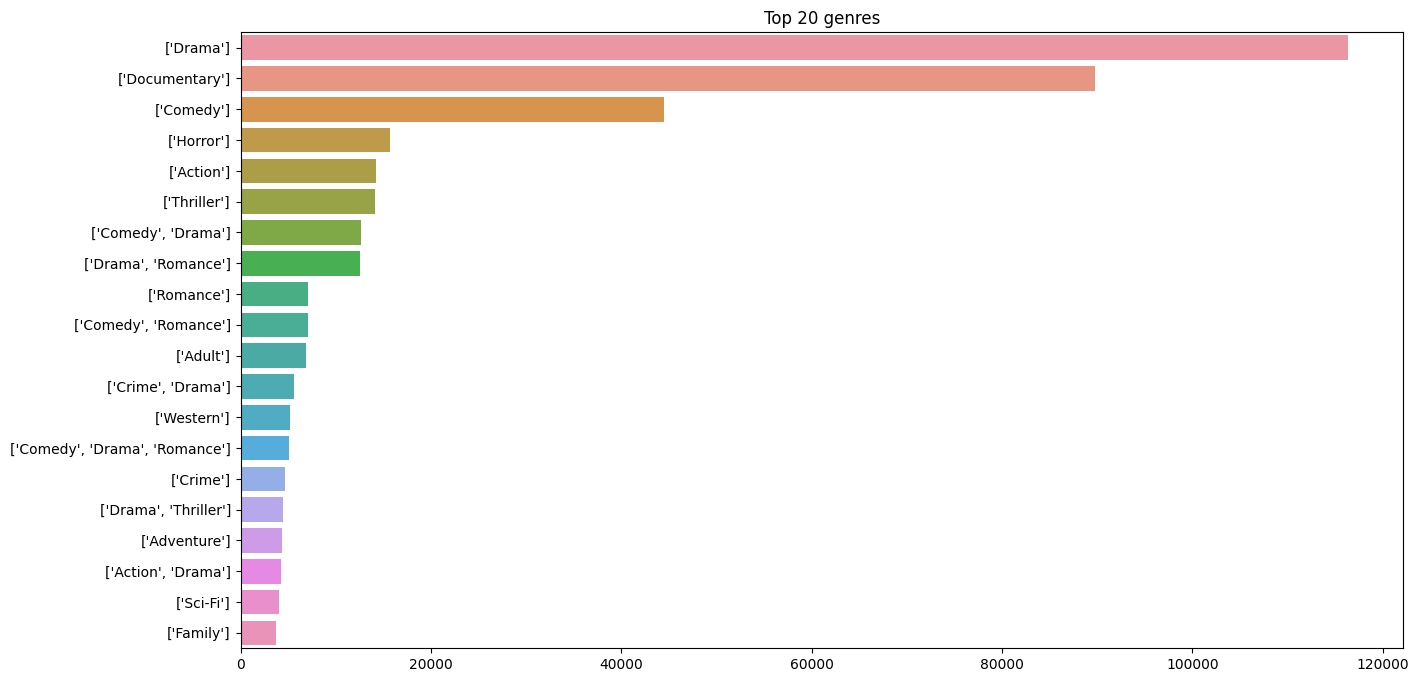

In [3]:
df_genre = df_movie.copy()
df_genre.dropna(subset=['Movie genres names'], inplace=True)
count_genre = df_genre['Movie genres names'].value_counts()
plt.figure(figsize=(15,8))
ax = sns.barplot(x=count_genre.values[0:20], y=count_genre.index[0:20]).set(title='Top 20 genres')
plt.show()

Below is the distribution of individual genres:

In [4]:
data = df_movie[['Movie genres names']].dropna()
movie_genres = [ast.literal_eval(movie_genre) for movie_genre in data['Movie genres names']]
counts = pd.Series([genre for sublist in movie_genres for genre in sublist]).value_counts()
counts

Drama          225298
Documentary    117300
Comedy         106079
Action          52339
Romance         45962
Thriller        42906
Crime           35899
Horror          35347
Adventure       27349
Family          17170
Biography       16683
Mystery         16283
Fantasy         14782
History         13829
Sci-Fi          13419
Music           11871
Musical         10037
War              9126
Adult            8822
Animation        8607
Western          8096
Sport            6825
News             1441
Film-Noir         856
Reality-TV        488
Talk-Show         163
Short              57
Game-Show          28
dtype: int64

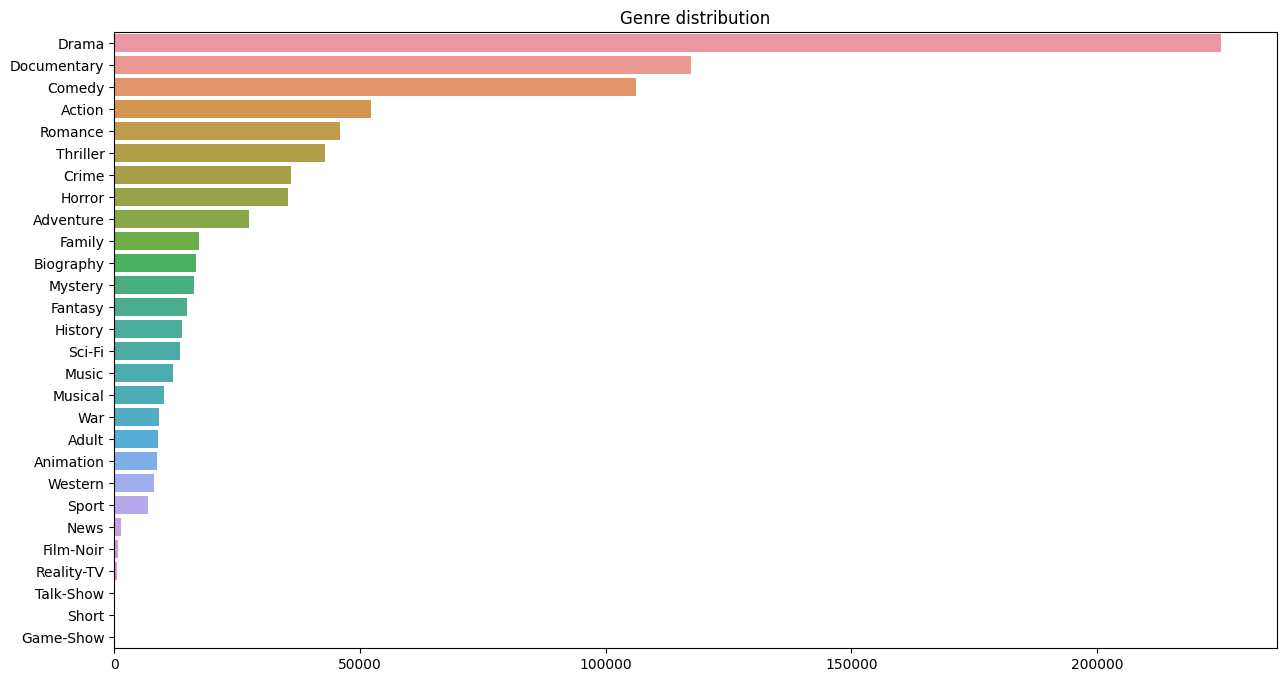

In [5]:
plt.figure(figsize=(15,8))
ax = sns.barplot(x=counts.values, y=counts.index).set(title='Genre distribution')
plt.show()

### 1) Data preprocessing: creation of dummies for genres

From the plot above we remark that some categories are actually an ensemble of several categories.
For example there is the category Commedy & Drama.
Here we want to split the genres in subunits of single genre. 
This can be done through the help of dummies.

For the analysis of this section, we are going to focus only on rating, budget and revenue.
This is way we can only keep these variables.

In [6]:
data = df_movie[['Movie genres names', 'averageRating', 'inflation corrected budget', 'inflation corrected revenue']].dropna()

If we recount the total number of movies in each category in the case of dummies, we remark that the total number of categories is 23.
The drama is leading with more that 2600 movies, followed by comedy and action.

In [7]:
movie_genres = [ast.literal_eval(movie_genre) for movie_genre in data['Movie genres names']]
counts = pd.Series([genre for sublist in movie_genres for genre in sublist]).value_counts()
counts

Drama          2615
Comedy         1883
Action         1399
Crime          1025
Romance         911
Adventure       881
Thriller        872
Horror          598
Mystery         488
Fantasy         446
Sci-Fi          435
Biography       314
Family          252
History         178
Music           167
Sport           120
War             106
Musical          61
Animation        50
Western          45
Documentary      39
Adult             2
News              2
dtype: int64

Let's create the dummy variables.

In [8]:
data, genre_names = incorporate_genre_dummies(data)

We rename some variables because of the notation of linear regression that we are going to use later.

In [9]:
#data.rename(columns={'inflation corrected revenue' : 'corr_revenue', 'inflation corrected budget' : 'corr_budget'}, inplace = True)
data.rename(columns={'Movie genres names' : 'genre','inflation corrected revenue' : 'corr_revenue', 'inflation corrected budget' : 'corr_budget'}, inplace = True)

Because there are only two Adult and News movies left, there are not enough to represent their categories, so they are removed. Music and Musical represent similar genres of movies; therefore, they are combined.

In [10]:
data = data.drop(columns = ['Adult','News'])
genre_names.remove('Adult')
genre_names.remove('News')
data['Music'] = np.logical_or(data['Music'], data['Musical']).astype(int)
data = data.drop(columns = ['Musical'])
genre_names.remove('Musical')

Let's add columns for the logarithm of the revenue and budget.

In [11]:
data['log_revenue'] = np.log(data['corr_revenue'])
data['log_budget'] = np.log(data['corr_budget'])

In [12]:
data.head(2)

,genre,averageRating,corr_budget,corr_revenue,Action,Adventure,Animation,Biography,Comedy,Crime,...,Music,Mystery,Romance,SciFi,Sport,Thriller,War,Western,log_revenue,log_budget
33,"['Crime', 'Drama']",7.6,4.578426e+06,4.692887e+06,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,15.361558,15.336866
225,"['Action', 'Comedy']",7.0,7.431127e+07,2.694641e+08,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,19.411946,18.123773


### 2) Genre distribution

Once we have prepared the dataset for the analysis we want to explore the genre distribution for rating, revenue and budget.

#### 2.1) Distribution of the rating across genre

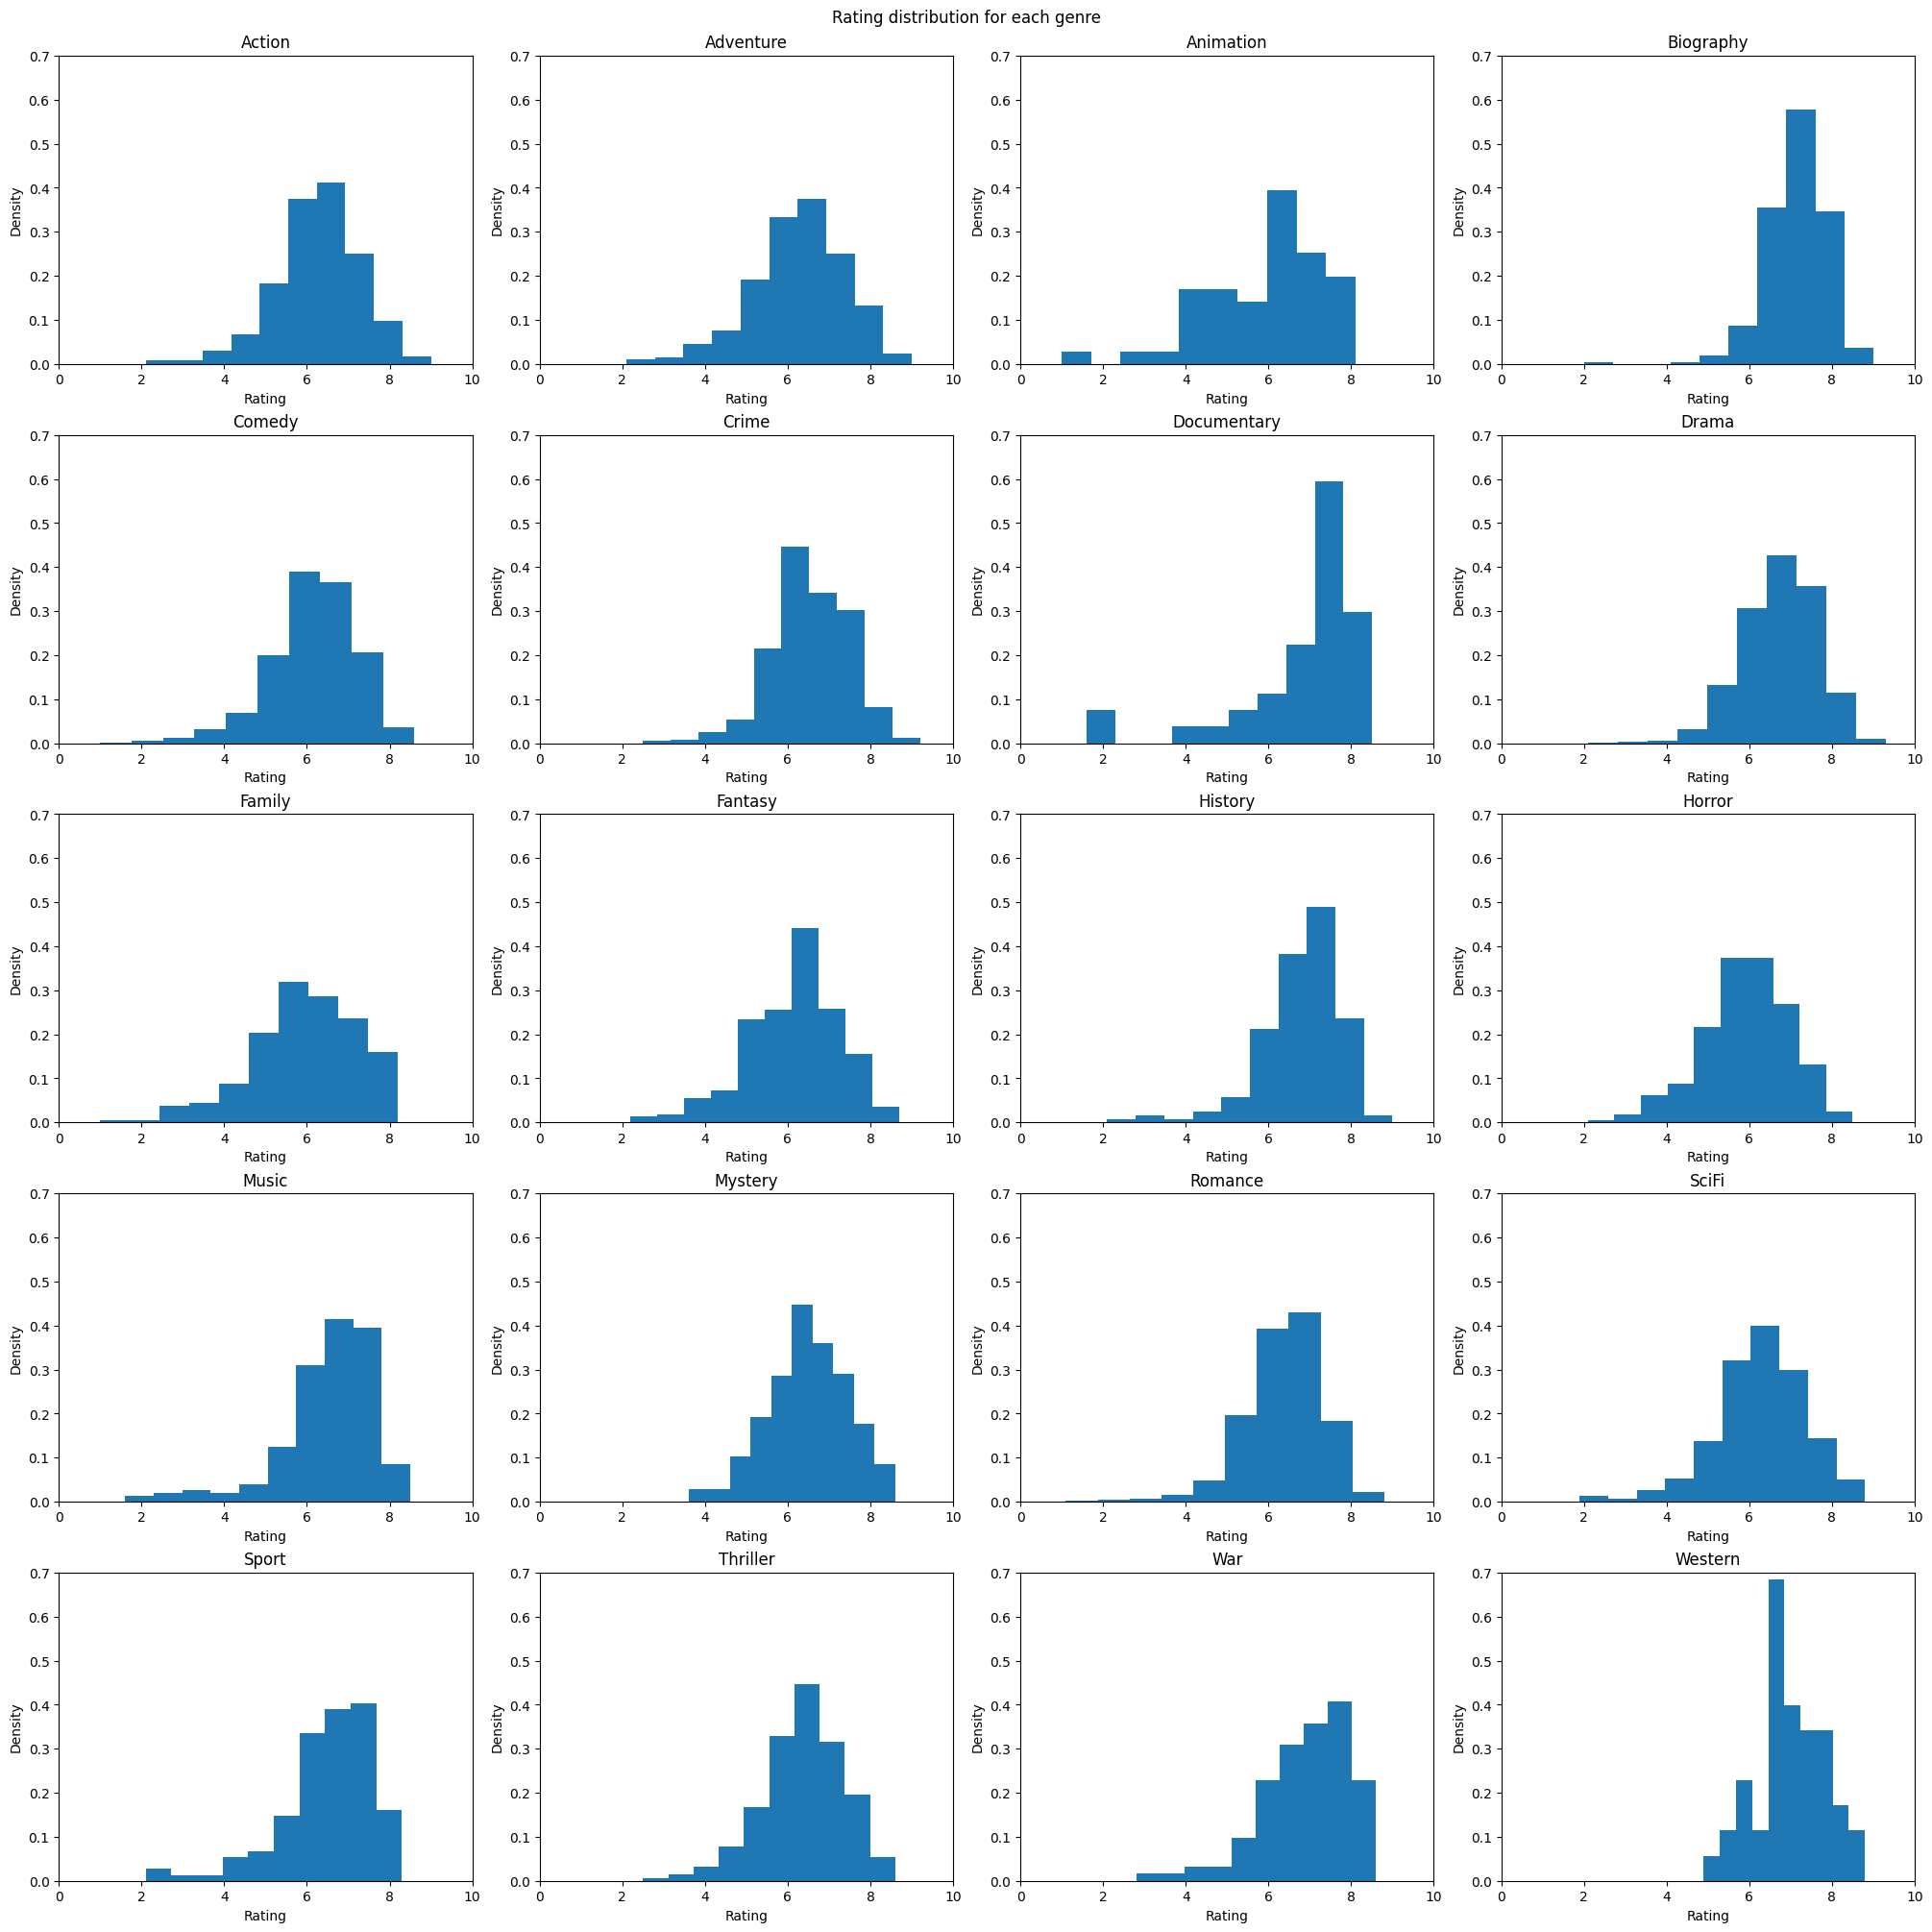

In [13]:
hist_subplots(data, 'averageRating', genre_names, 'Rating distribution for each genre', 'Rating', (0,10), (0,0.7) )

We remark that in general the distributions seem to be heavy-tailed, with their maximum towords more positive rating.
We remind that the rating are in the range $[0,10]$, where $10$ is the maximum.

By looking that the plot of the mean value with the respecting 95% confidence interval, we see that some genres have mean value significantly different from each other.
Biography, news, war and wester seems to have higher mean values that the other categories.

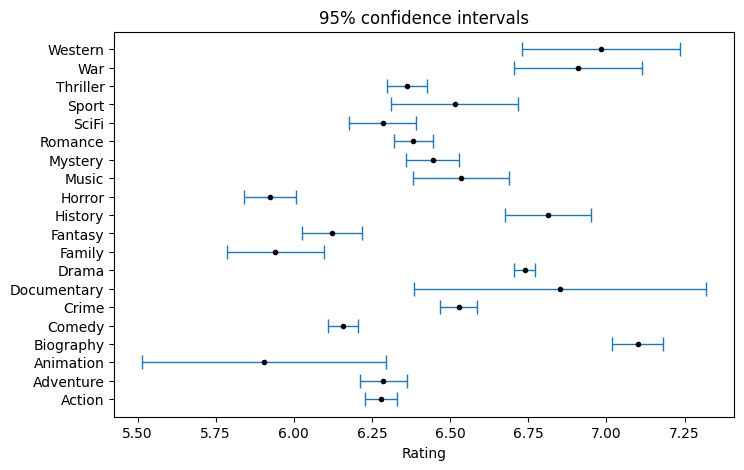

In [14]:
CIs = []    
    
for g in genre_names:
    difference_in_usage(data, g=g, CI_list=CIs, measure='averageRating')
    
plot_CIs(CIs, genre_names, 'Rating')

#### 2.2) Distribution of the budget across genre


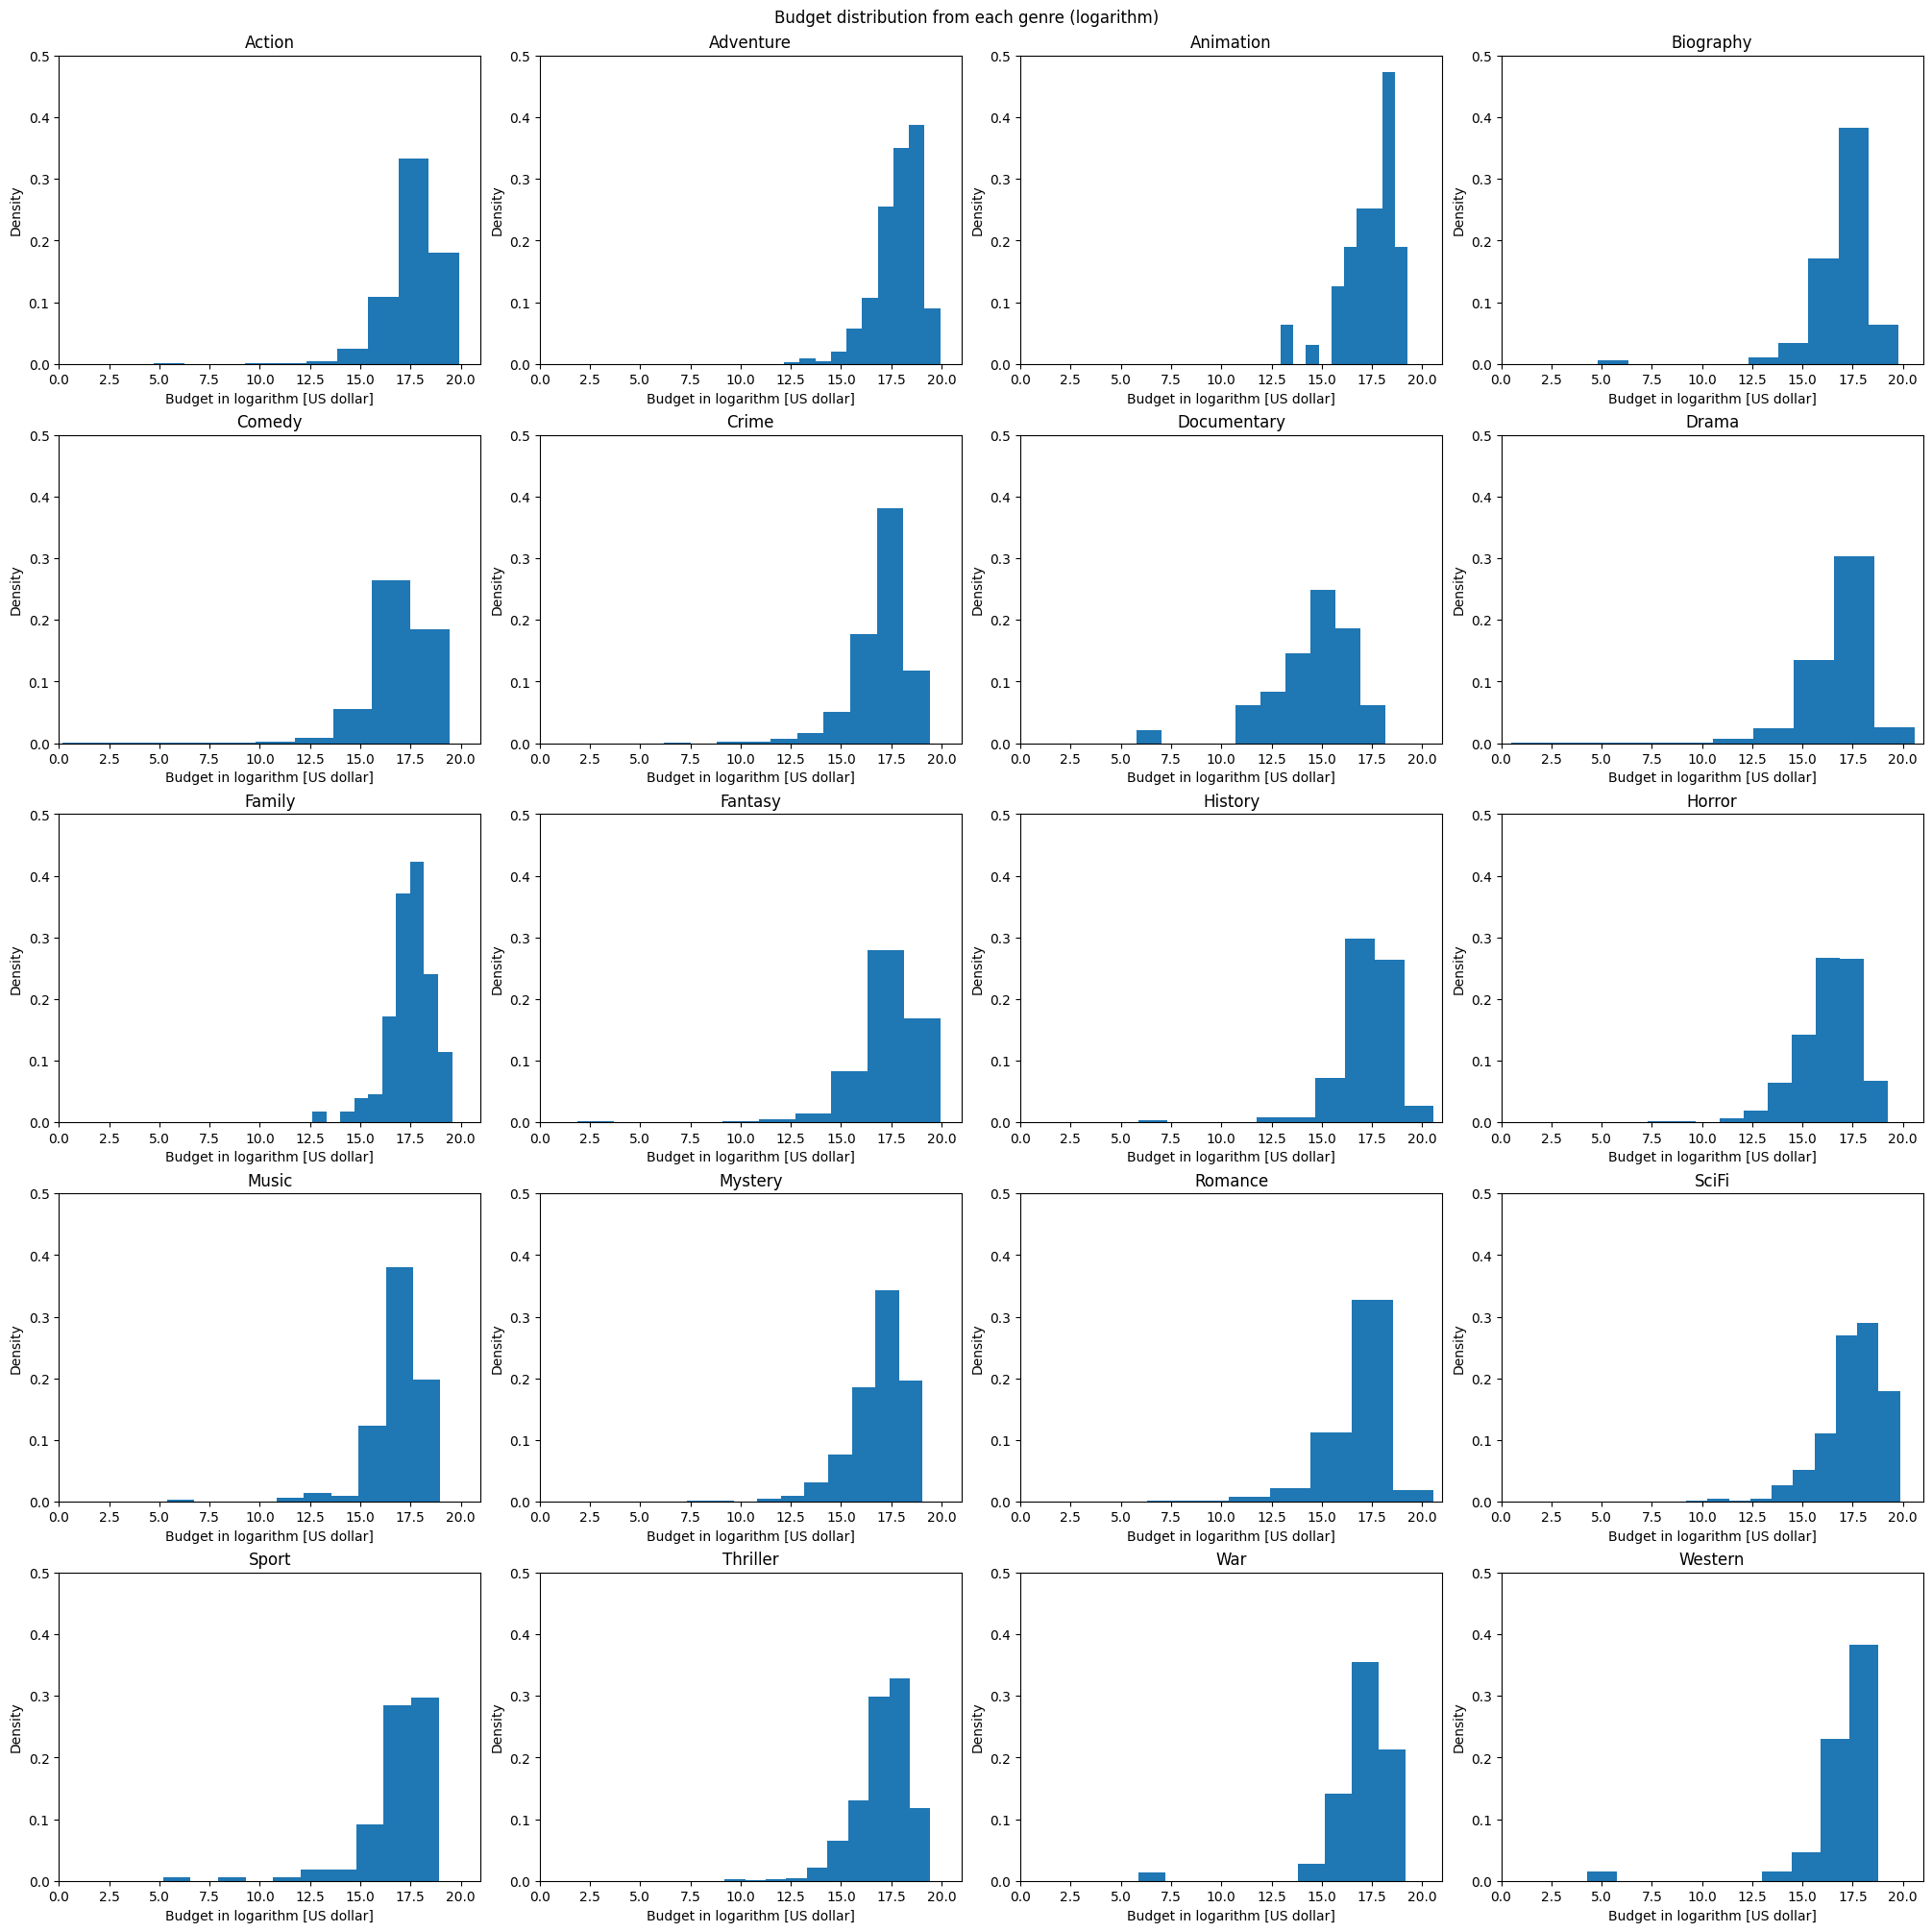

In [15]:
 hist_subplots(data, 'log_budget', genre_names, 'Budget distribution from each genre (logarithm)', 'Budget in logarithm [US dollar]', (0,21), (0,0.5))

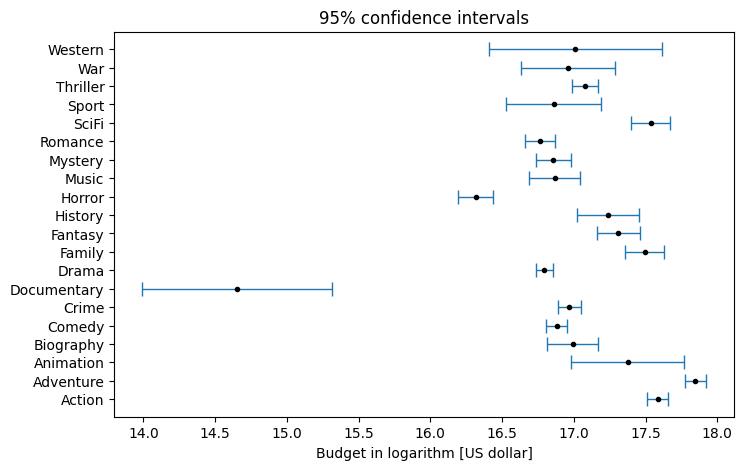

In [16]:
CIs = []
for g in genre_names:
    difference_in_usage(data, g=g, CI_list=CIs, measure='log_budget')
    
plot_CIs(CIs, genre_names, 'Budget in logarithm [US dollar]')

If we look that the mean value of the log budget, we remark that documentaries have low budget compared to all the others.
Adventure movies have significant higher budget than the others. 

#### 2.3) Distribution of the revenue across genre


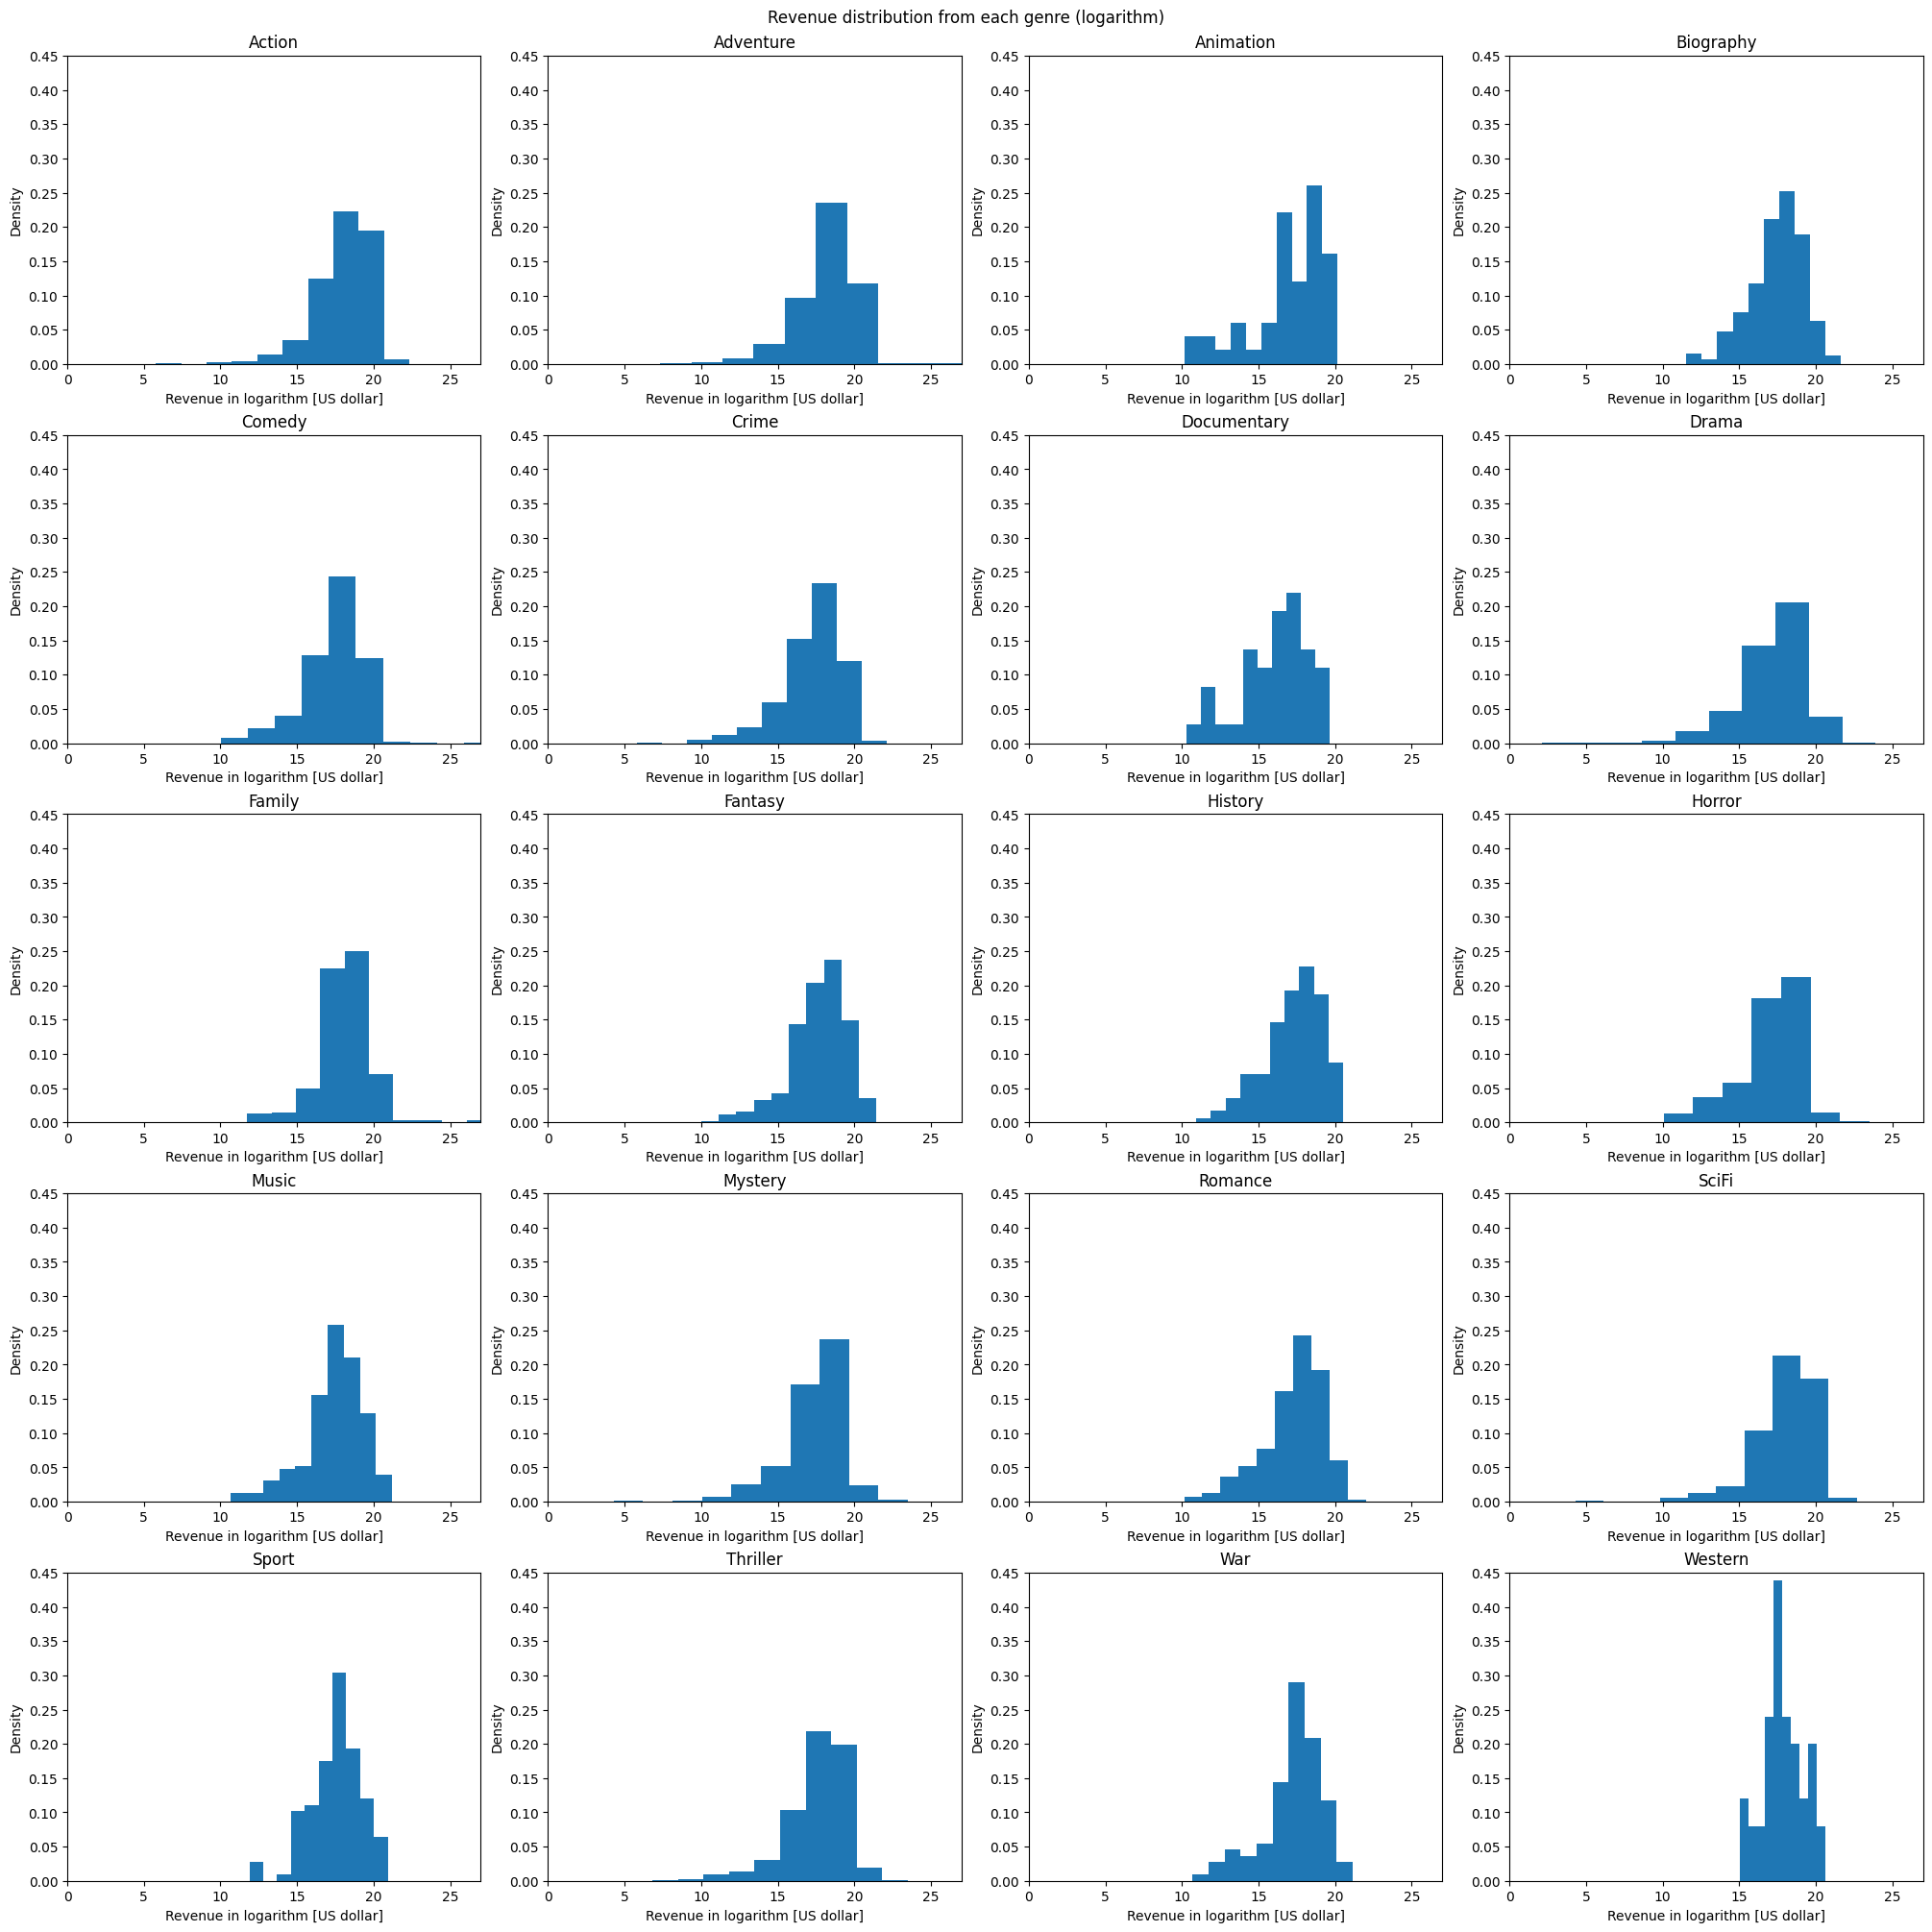

In [17]:
 hist_subplots(data, 'log_revenue', genre_names, 'Revenue distribution from each genre (logarithm)', 'Revenue in logarithm [US dollar]', (0,27), (0,0.45))

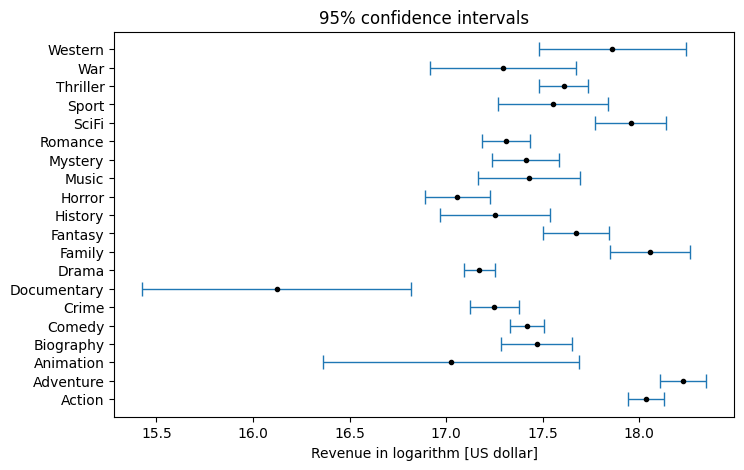

In [18]:
CIs = []
for g in genre_names:
    difference_in_usage(data, g=g, CI_list=CIs, measure='log_revenue')
    
plot_CIs(CIs, genre_names, 'Revenue in logarithm [US dollar]')

Adventure movies seem to have significantly higher revenue than the others, except for western, science fiction, family, and action movies. 
Documentaries have a significantly lower revenue than the others, except for animation movies. Both have respectively the higher and lower budget. However, concerning the rating, the results are different. Documentaries, for example, which have a lower budget and revenue than the others, are significantly higher rated than horror, fantasy, family, comedy, animation, adventure, and action films.

Let's now try to perform some linear regressions in order to predict our variables of interest, rating and revenue, with the help of the genre and the budget.

### 3) Linear regression: average ratings and revenue

Here we create a function that is going to be useful for the visualisation of the coefficient of the linear regressions.

#### 3.1) Rating in function of the genres

We want to try to linearly predict the rating based on the genre.

In [19]:
mod = smf.ols(formula="averageRating ~ Action + Adventure +\
       Animation + Biography + Comedy + Crime + Documentary + Drama +\
       Family + Fantasy + History + Horror + Music + Mystery +\
       Romance + SciFi + Sport + Thriller + War + Western", data=data)

res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:          averageRating   R-squared:                       0.158
Model:                            OLS   Adj. R-squared:                  0.154
Method:                 Least Squares   F-statistic:                     47.02
Date:                Tue, 13 Dec 2022   Prob (F-statistic):          4.43e-170
Time:                        14:19:00   Log-Likelihood:                -6976.2
No. Observations:                5042   AIC:                         1.399e+04
Df Residuals:                    5021   BIC:                         1.413e+04
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       6.3980      0.060    105.773      

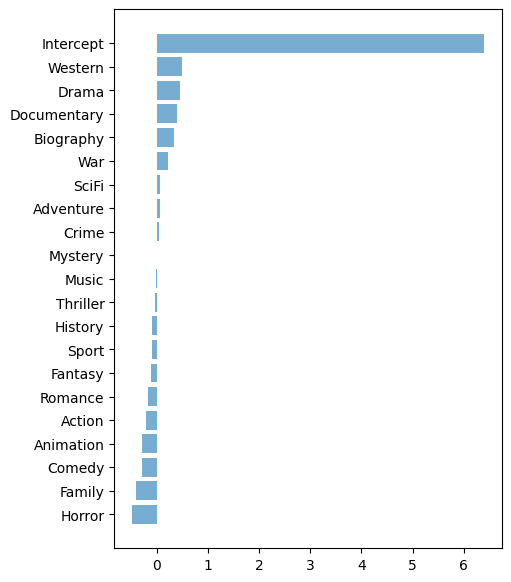

In [20]:
barplot(res)

**Biography, Documentary, Drama, Western** are significantly driving the grades upwards, while **Action, Comedy, Family, Horror and Romance** drive it downwards.
We have to remark that the R square of this regression is very low, not even 0.2. The model does not describe well our response variable.

But what if we keep the genre together without using dummies varibles?

In [21]:
mod = smf.ols(formula="averageRating ~ genre", data=data)

res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:          averageRating   R-squared:                       0.258
Model:                            OLS   Adj. R-squared:                  0.202
Method:                 Least Squares   F-statistic:                     4.602
Date:                Tue, 13 Dec 2022   Prob (F-statistic):          3.52e-132
Time:                        14:19:01   Log-Likelihood:                -6657.0
No. Observations:                5042   AIC:                         1.402e+04
Df Residuals:                    4687   BIC:                         1.634e+04
Df Model:                         354                                         
Covariance Type:            nonrobust                                         
                                                       coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------

We obtain a higher R square! The genre not split better capture the rating!

#### 3.2) Log revenue in function of the genre

We can perform the same analysis of before but the the logarithm of the revenue as response variable.
The result is presented below.

In [22]:
mod = smf.ols(formula="log_revenue ~ Action + Adventure + \
       Animation + Biography + Comedy + Crime + Documentary + Drama +\
       Family + Fantasy + History + Horror + Music + Mystery +\
       Romance + SciFi + Sport + Thriller + War + Western", data=data)

res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:            log_revenue   R-squared:                       0.080
Model:                            OLS   Adj. R-squared:                  0.076
Method:                 Least Squares   F-statistic:                     21.70
Date:                Tue, 13 Dec 2022   Prob (F-statistic):           6.21e-76
Time:                        14:19:01   Log-Likelihood:                -10479.
No. Observations:                5042   AIC:                         2.100e+04
Df Residuals:                    5021   BIC:                         2.114e+04
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      17.0369      0.121    140.610      

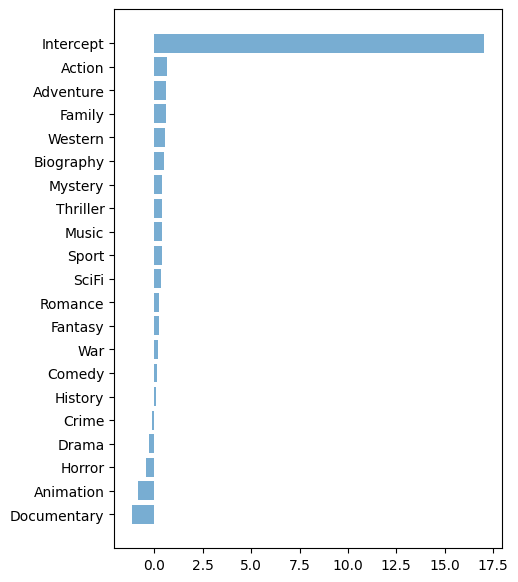

In [23]:
barplot(res)

**Action, Adventure, Biography, Family, Mystery, Thriller** are significantly driving the revenue upwards, while **Animation, Documentary, Drama and Horror** drive it downwards.
Again the R squared is very low, even lower than for the case of the rating.
This model does not predict our response variable.

It seems that the genre is not helpful to linearly predict the rating and the log revenue.

Some genres have a similar effect on rating and revenue, like **Biography (upward) and Horror (downward)**. While **Action** movies are generally associated to a bad movie, it paradoxically generates a lot of revenue. On the contrary, while **Documentaries** are well graded, they produce little revenue.
Let's try to captue this in one regression using interactions.

In [24]:
mod = smf.ols(formula="log_revenue ~ Comedy*Romance + \
                                    Comedy*Drama + \
                                    Drama*Romance ", data=data)

res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:            log_revenue   R-squared:                       0.026
Model:                            OLS   Adj. R-squared:                  0.025
Method:                 Least Squares   F-statistic:                     22.51
Date:                Tue, 13 Dec 2022   Prob (F-statistic):           2.57e-26
Time:                        14:19:02   Log-Likelihood:                -10621.
No. Observations:                5042   AIC:                         2.126e+04
Df Residuals:                    5035   BIC:                         2.130e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         17.9175      0.058    310.

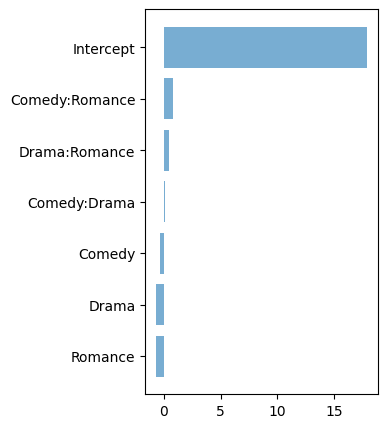

In [25]:
barplot(res, figsize=(3,5))

Interestingly, for very common genre associations, we observe that their combination has a positive effect on revenue, while the genre alone tend to provoke a decrease. But the R value decreased.

Again let's try to use the original genres:

In [26]:
mod = smf.ols(formula="log_revenue ~ genre ", data=data)

res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:            log_revenue   R-squared:                       0.171
Model:                            OLS   Adj. R-squared:                  0.108
Method:                 Least Squares   F-statistic:                     2.726
Date:                Tue, 13 Dec 2022   Prob (F-statistic):           1.38e-50
Time:                        14:19:03   Log-Likelihood:                -10216.
No. Observations:                5042   AIC:                         2.114e+04
Df Residuals:                    4687   BIC:                         2.346e+04
Df Model:                         354                                         
Covariance Type:            nonrobust                                         
                                                       coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------

Again, the R squred is much higher! It  is better to use to original genre.

### Boxplots

In [27]:
budget, revenue, rating = list(), list(), list()
for genre in genre_names:
    budget.append(data[data[genre] == 1]['log_budget'])
    revenue.append(data[data[genre] == 1]['log_revenue'])
    rating.append(data[data[genre] == 1]['averageRating'])

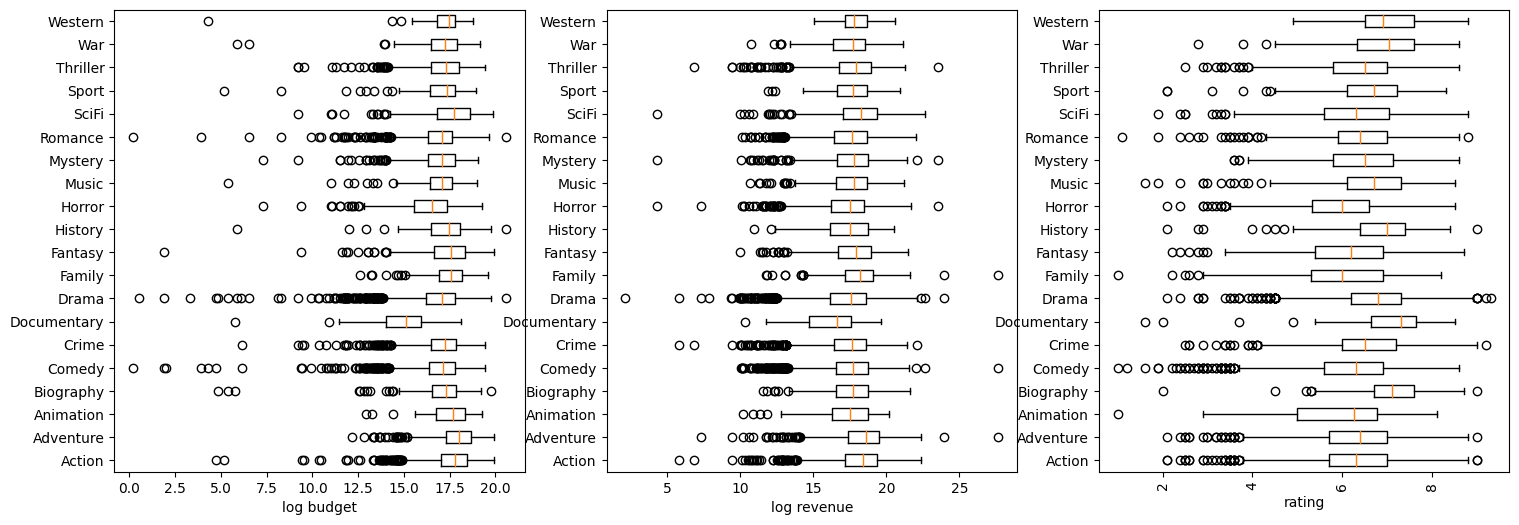

In [28]:
fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize=(18,6))
axs[0].boxplot(budget, labels=genre_names, vert = False)
axs[0].set_xlabel('log budget')
axs[1].boxplot(revenue, labels=genre_names, vert = False)
axs[1].set_xlabel('log revenue')
axs[2].boxplot(rating, labels=genre_names, vert = False)
axs[2].set_xlabel('rating')
plt.xticks(rotation=90)
plt.show()

Useful ?

### 4) Low budget and high revenue
#### Scatter plot

Let's try to look at region where the budget is low and the revenue is high.
For this we use a linear regression and we select a threshold for detecting the low budget.

In [29]:
mod = smf.ols(formula="log_revenue ~ log_budget ", data=data)
res = mod.fit()

In [30]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            log_revenue   R-squared:                       0.277
Model:                            OLS   Adj. R-squared:                  0.277
Method:                 Least Squares   F-statistic:                     1932.
Date:                Tue, 13 Dec 2022   Prob (F-statistic):               0.00
Time:                        14:19:07   Log-Likelihood:                -9869.6
No. Observations:                5042   AIC:                         1.974e+04
Df Residuals:                    5040   BIC:                         1.976e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      6.0866      0.259     23.463      0.000       5.578       6.595
log_budget     0.6697      0.015     43.959      0.000       0.640       0.700
==============================================================================
Omnibus:                      948.869   Durbin-Watson:                   1.878
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5703.478
Skew:                          -0.762   Prob(JB):                         0.00
Kurtosis:                       7.983   Cond. No.                         184.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [31]:
coef = res.params.values

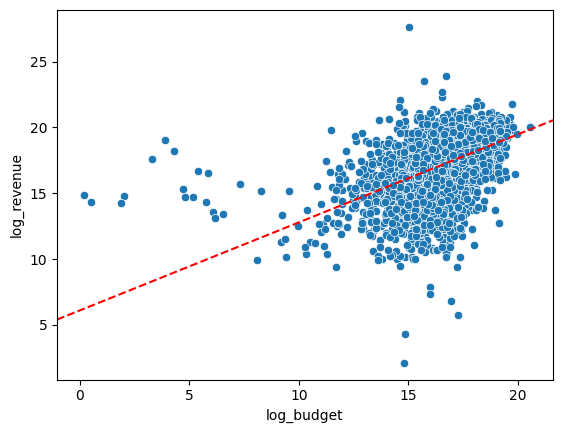

In [32]:
fig = sns.scatterplot(x=data.log_budget,y=data.log_revenue)
fig.axline((0,coef[0]), slope=coef[1], color='red', label='Linear fit',linestyle='dashed')
plt.show()

Let's select the movies with log budget lower than 7. 
In this region we see that all the movies are above the regression line, therefore they have a quite high revenue compared to the budget.

In [33]:
low_budget = data.loc[data.log_budget <= 7]

In [34]:
df = low_budget.copy()
df = df.drop(columns = ['genre','averageRating','corr_budget','corr_revenue','log_revenue','log_budget'])

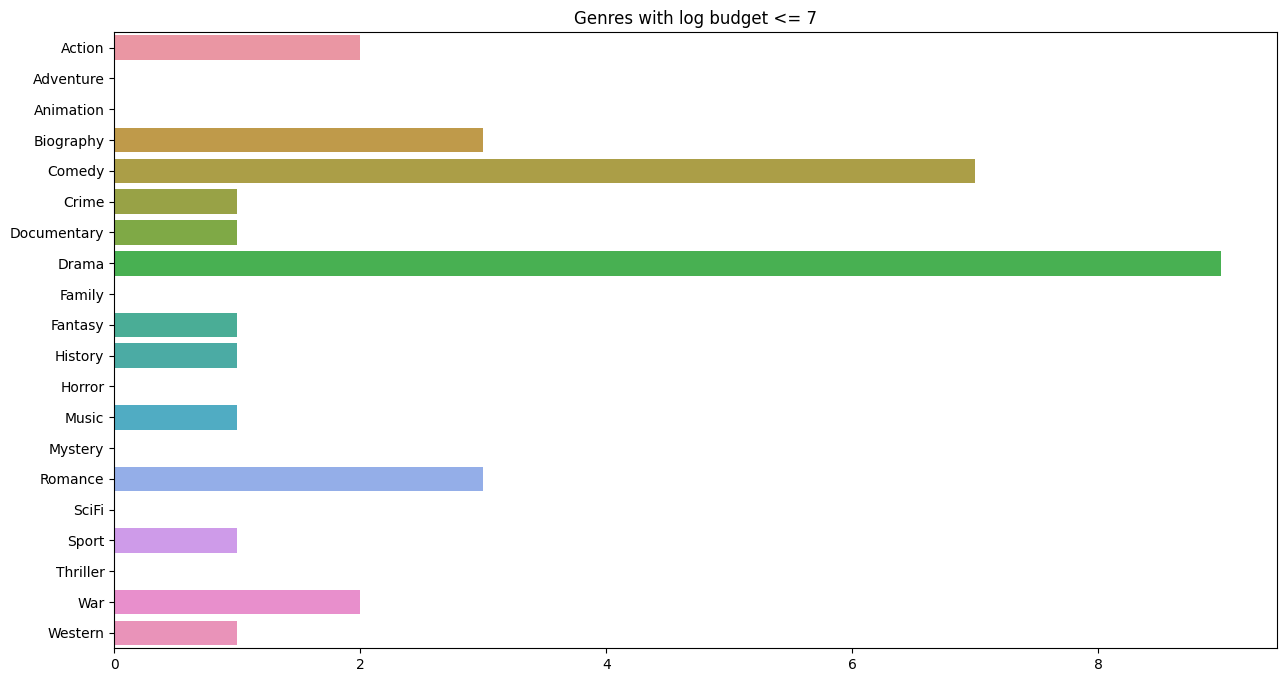

In [35]:
genres = df.columns
tot = []
for gen in genres:
    tot.append(sum(df[gen]))
plt.figure(figsize=(15,8))
ax = sns.barplot(x=tot, y=genres).set(title='Genres with log budget <= 7')
plt.show()

Above we see a representation of the genre in the case of low budget.
There are a lot of drama movies, this could be due by the fact that there are a lot of drama movies in the datset.
By dividing the values here by the total number of movie sin each categories we should see a bit better the situation.

In [36]:
all_tot = []
for gen in genres:
    all_tot.append(sum(data[gen]))

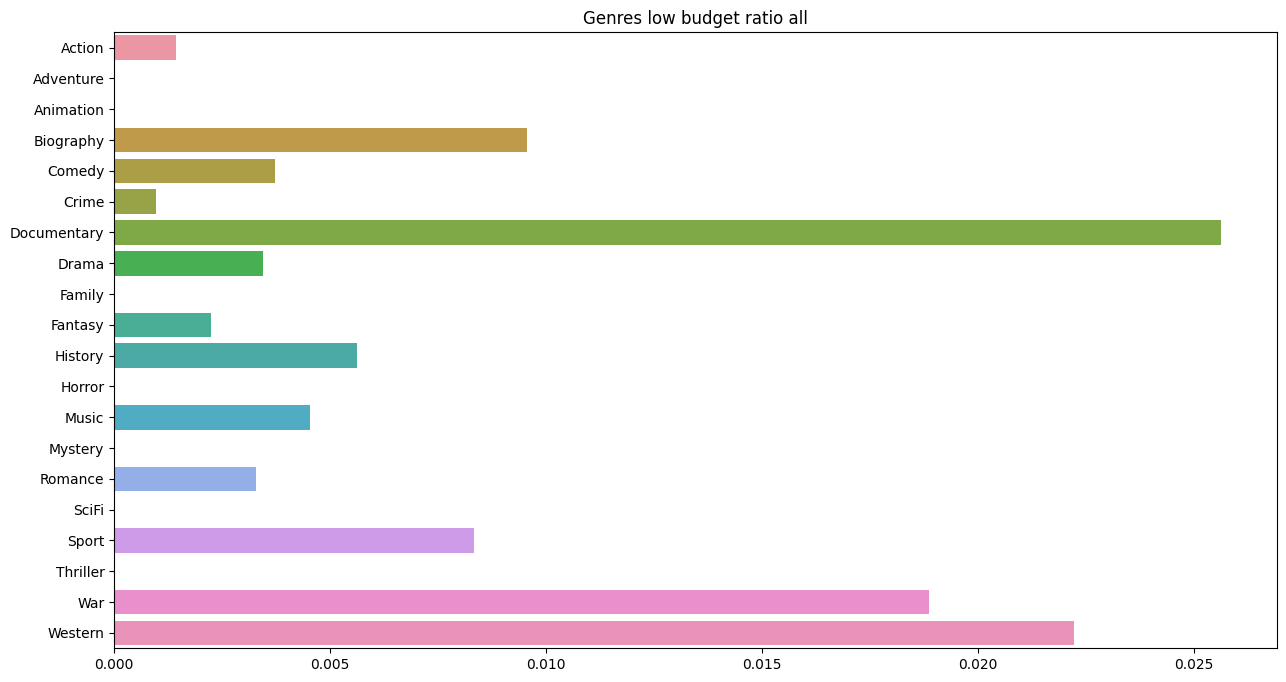

In [37]:
plt.figure(figsize=(15,8))
ax = sns.barplot(x=np.array(tot)/np.array(all_tot), y=genres).set(title='Genres low budget ratio all')
plt.show()

Now it seems that documentary and western are quite present in this low budget region.

We focused on low budget movies but now we can also try to look at movies that earn 10 times more than their budget.

In [38]:
high_revenue = data.loc[data.log_revenue >= (np.log(10) + data.log_budget)]
#high_revenue = data.copy()

In [39]:
df = high_revenue.copy()
df = df.drop(columns = ['genre','averageRating','corr_budget','corr_revenue','log_revenue','log_budget'])

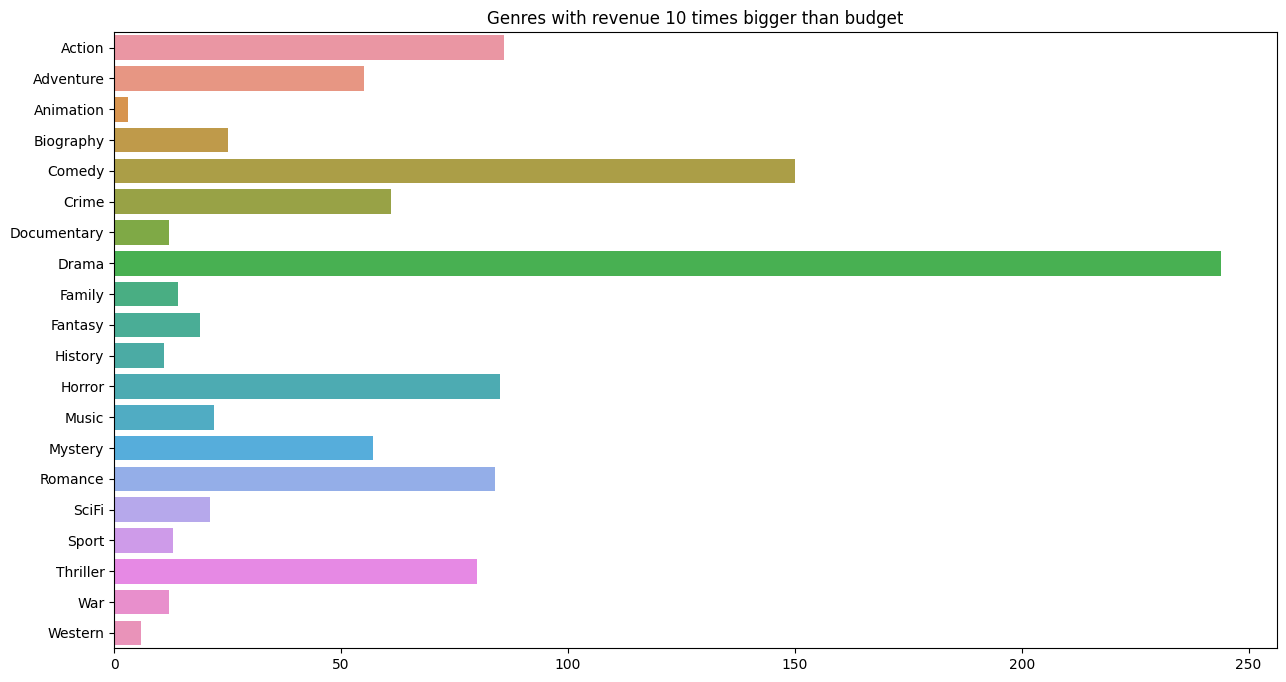

In [40]:
genres = df.columns
tot = []
for gen in genres:
    tot.append(sum(df[gen]))
plt.figure(figsize=(15,8))
ax = sns.barplot(x=tot, y=genres).set(title='Genres with revenue 10 times bigger than budget')
plt.show()

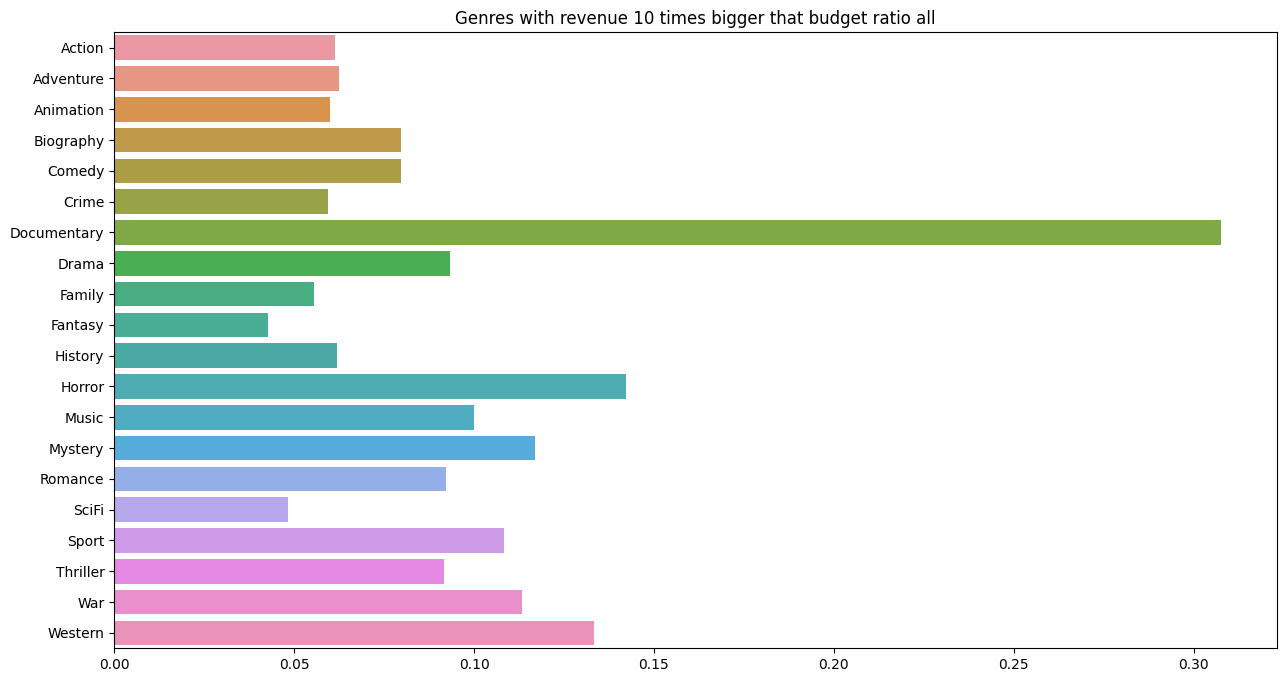

In [41]:
plt.figure(figsize=(15,8))
ax = sns.barplot(x=np.array(tot)/np.array(all_tot), y=genres).set(title='Genres with revenue 10 times bigger that budget ratio all')
plt.show()

By comparing the revenue with the budget (revenue is 10x higher than the budget), the proportion of documentary movies is the highest, followed by horror and Western movies.

# Genre across time
We want to observe if some evolution occurs across time.

In [3]:
data_time = df_movie[['Movie genres names', 'Movie release date', 'averageRating', 'inflation corrected budget', 'inflation corrected revenue']].dropna()
data_time, genre_names = incorporate_genre_dummies(data_time)
data_time.rename(columns={'Movie genres names' : 'genre', 'Movie release date':'date', 'inflation corrected revenue' : 'corr_revenue', 'inflation corrected budget' : 'corr_budget'}, inplace = True)
data_time['log_revenue'] = np.log(data_time['corr_revenue'])
data_time['log_budget'] = np.log(data_time['corr_budget'])
data_time.head(3)

,genre,date,averageRating,corr_budget,corr_revenue,Action,Adult,Adventure,Animation,Biography,...,Mystery,News,Romance,SciFi,Sport,Thriller,War,Western,log_revenue,log_budget
33,"['Crime', 'Drama']",2014.0,7.6,4.578426e+06,4.692887e+06,0,0,0,0,0,...,0,0,0,0,0,0,0,0,15.361558,15.336866
225,"['Action', 'Comedy']",2015.0,7.0,7.431127e+07,2.694641e+08,1,0,0,0,0,...,0,0,0,0,0,0,0,0,19.411946,18.123773
446,['Comedy'],2014.0,6.7,3.891662e+06,1.236175e+06,0,0,0,0,0,...,0,0,0,0,0,0,0,0,14.027532,15.174347


In [4]:
data_time = data_time.drop(columns = ['Adult','News'])
genre_names.remove('Adult')
genre_names.remove('News')
data_time['Music'] = np.logical_or(data_time['Music'], data_time['Musical']).astype(int)
data_time = data_time.drop(columns = ['Musical'])
genre_names.remove('Musical')

In [5]:
# split data in two periods: from 1959 to 2000 and from 2000 to 2021.
old_movies = data_time[data_time.date < 2000]
recent_movies = data_time[data_time.date >= 2000]

In [6]:
# number of movie genres in the first period (before 2000) = []
movie_genres = [ast.literal_eval(movie_genre) for movie_genre in old_movies.genre]
pd.Series([genre for sublist in movie_genres for genre in sublist]).value_counts()

Drama          1063
Comedy          799
Action          514
Crime           456
Thriller        373
Romance         359
Adventure       326
Horror          265
Mystery         185
Sci-Fi          176
Fantasy         175
Family          105
Biography       104
Music            73
History          61
War              56
Sport            53
Western          33
Musical          28
Animation         7
Documentary       4
Adult             2
dtype: int64

In [7]:
# number of movie genres in the second period (after 2000 included)
movie_genres = [ast.literal_eval(movie_genre) for movie_genre in recent_movies.genre]
pd.Series([genre for sublist in movie_genres for genre in sublist]).value_counts()

Drama          1552
Comedy         1084
Action          885
Crime           569
Adventure       555
Romance         552
Thriller        499
Horror          333
Mystery         303
Fantasy         271
Sci-Fi          259
Biography       210
Family          147
History         117
Music            94
Sport            67
War              50
Animation        43
Documentary      35
Musical          33
Western          12
News              2
dtype: int64

Here, the first popular genres seem to be similar. Indeed, Drama, Comedy, Action and Crime remain all the 4 more represented movie genres in both periods. 

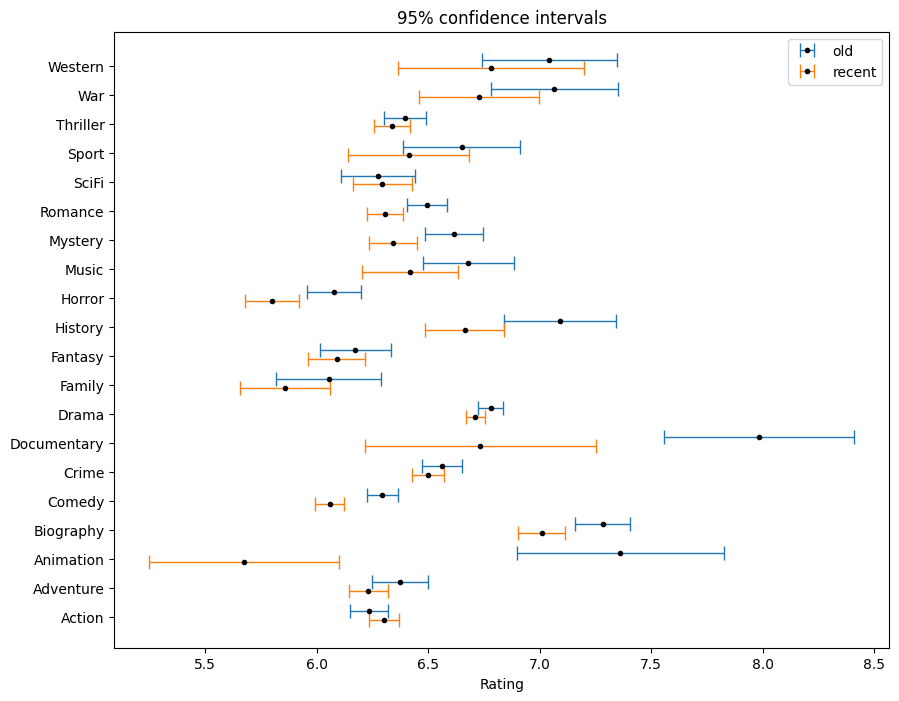

In [8]:
# Confidence interval according to the ratings
recent_CIs = []    
old_CIs = []    
    
for g in genre_names:
    difference_in_usage(old_movies, g=g, CI_list=old_CIs, measure='averageRating')
for g in genre_names:
    difference_in_usage(recent_movies, g=g, CI_list=recent_CIs, measure='averageRating')
    
plot_double_CIs(old_CIs, recent_CIs, genre_names, 'Rating')
plt.show()

Some genres show significant difference between the periods. In general, the old movies are better rated except for the action movies (but non-significant). Romance, Mystery, Horror, History, Documentary, Comedy, Biography, and Animation movies were significantly better rated before 2000. Are the movies worse, or is the population more critical? 

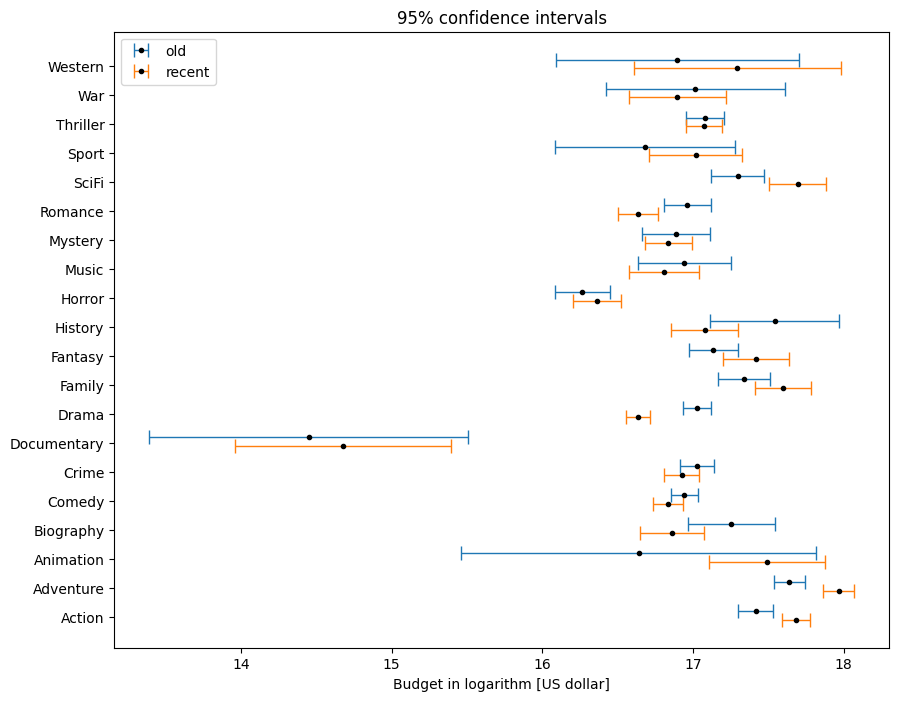

In [9]:
# Confidence interval according to the budget
recent_CIs = []    
old_CIs = []    
    
for g in genre_names:
    difference_in_usage(old_movies, g=g, CI_list=old_CIs, measure='log_budget')
for g in genre_names:
    difference_in_usage(recent_movies, g=g, CI_list=recent_CIs, measure='log_budget')
    
plot_double_CIs(old_CIs, recent_CIs, genre_names,  'Budget in logarithm [US dollar]')
plt.show()

Science fiction, Adventure, and Action movies show an significant increase in budget, whereas Romance and Drama movies undergo a significant decrease in their budget. 

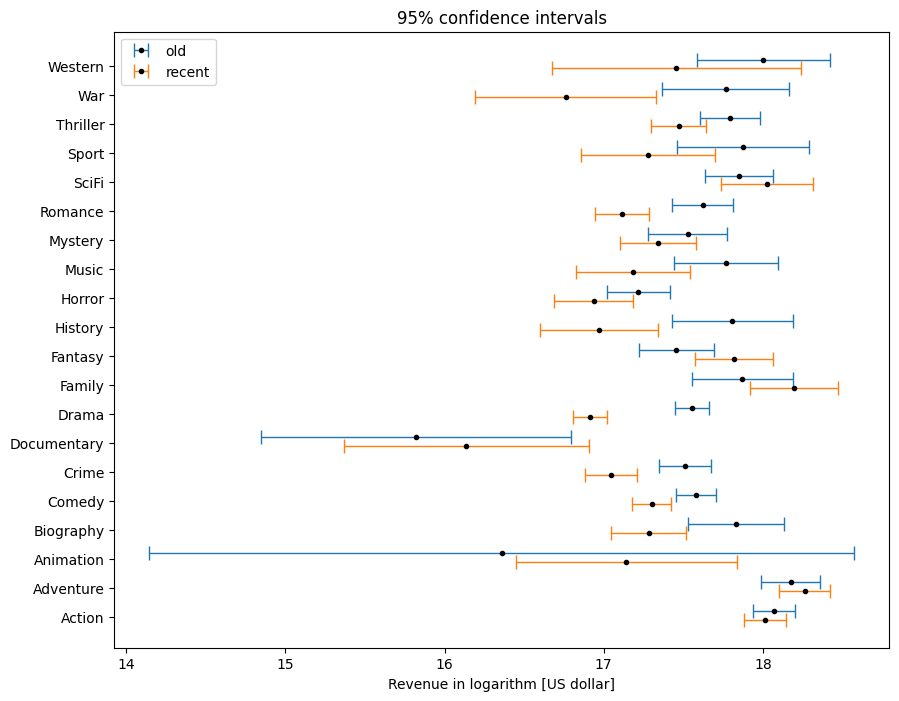

In [10]:
# Confidence interval according to the revenue
recent_CIs = []    
old_CIs = []    
    
for g in genre_names:
    difference_in_usage(old_movies, g=g, CI_list=old_CIs, measure='log_revenue')
for g in genre_names:
    difference_in_usage(recent_movies, g=g, CI_list=recent_CIs, measure='log_revenue')
    
plot_double_CIs(old_CIs, recent_CIs, genre_names,  'Revenue in logarithm [US dollar]')
plt.show()

No movie show significant increase in their revenue, whereas Romance, History, Drama, Crime, Comedy, and Biography movies have a significant decrease.
Thus, an significant increase in budget (such as for Action, Adventure, and Science fiction movies) does not mean an significant increase in the revenue.

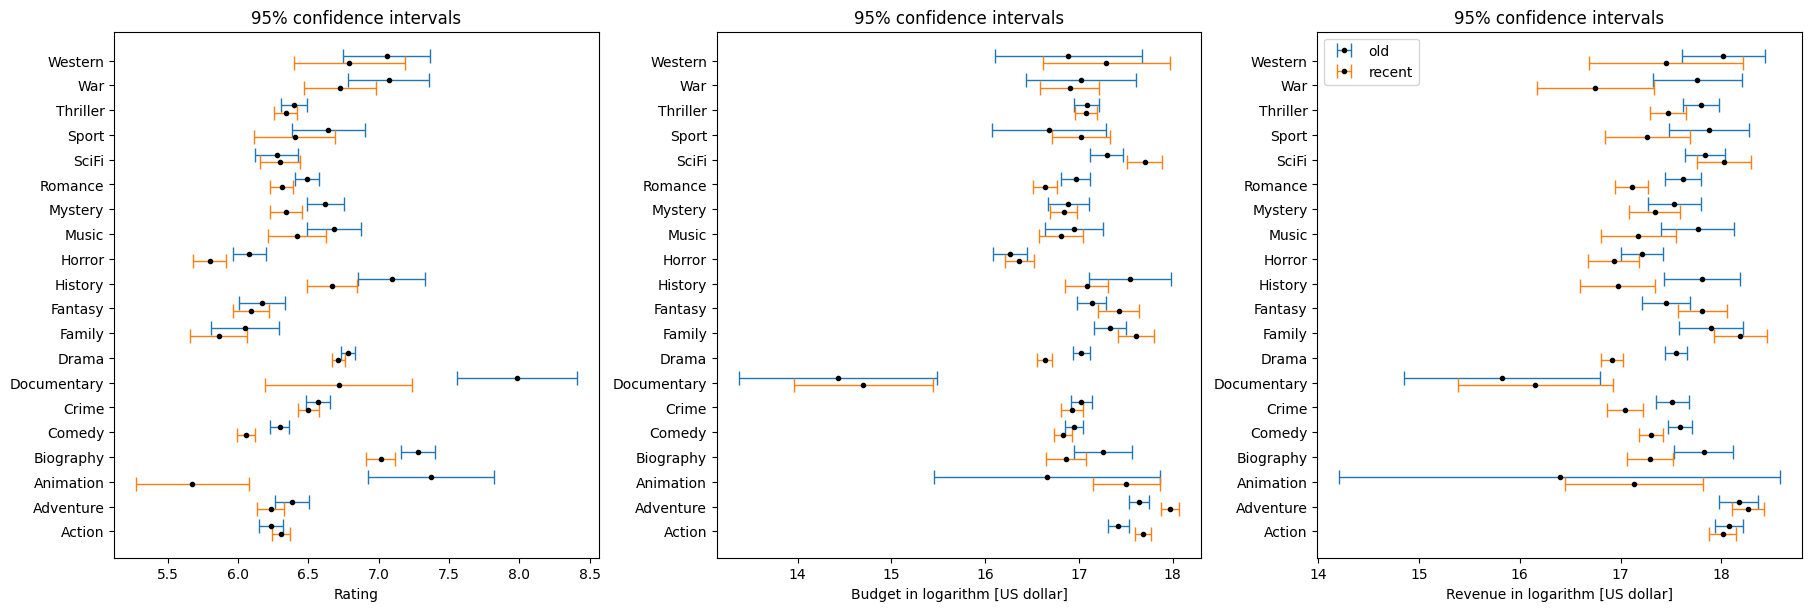

In [11]:
fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize=(18,6), constrained_layout=True)
# Rating
recent_CIs = []    
old_CIs = []     
for g in genre_names:
    difference_in_usage(old_movies, g=g, CI_list=old_CIs, measure='averageRating')
for g in genre_names:
    difference_in_usage(recent_movies, g=g, CI_list=recent_CIs, measure='averageRating')    
plot_double_CIs(old_CIs, recent_CIs, genre_names, 'Rating', n = 0, fig=fig, axs=axs)

# Budget
recent_CIs = []    
old_CIs = []    
for g in genre_names:
    difference_in_usage(old_movies, g=g, CI_list=old_CIs, measure='log_budget')
for g in genre_names:
    difference_in_usage(recent_movies, g=g, CI_list=recent_CIs, measure='log_budget')
plot_double_CIs(old_CIs, recent_CIs, genre_names,  'Budget in logarithm [US dollar]',  n = 1, fig=fig, axs=axs)

# Revenue
recent_CIs = []    
old_CIs = []    
for g in genre_names:
    difference_in_usage(old_movies, g=g, CI_list=old_CIs, measure='log_revenue')
for g in genre_names:
    difference_in_usage(recent_movies, g=g, CI_list=recent_CIs, measure='log_revenue')
plot_double_CIs(old_CIs, recent_CIs, genre_names,  'Revenue in logarithm [US dollar]', n = 2, fig=fig, axs=axs)



In [70]:
old_movies['diff_log_rev_bud'] = old_movies.log_revenue-old_movies.log_budget
recent_movies['diff_log_rev_bud'] = recent_movies.log_revenue-recent_movies.log_budget
old_movies.head(2)

C:\Users\rache\AppData\Local\Temp\ipykernel_15572\1455148246.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  old_movies['diff_log_rev_bud'] = old_movies.log_revenue-old_movies.log_budget
C:\Users\rache\AppData\Local\Temp\ipykernel_15572\1455148246.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recent_movies['diff_log_rev_bud'] = recent_movies.log_revenue-recent_movies.log_budget


,genre,date,averageRating,corr_budget,corr_revenue,Action,Adventure,Animation,Biography,Comedy,...,Mystery,Romance,SciFi,Sport,Thriller,War,Western,log_revenue,log_budget,diff_log_rev_bud
3849,"['Comedy', 'Drama', 'Fantasy']",1993.0,8.1,2.738616e+07,1.333818e+08,0,0,0,0,1,...,0,0,0,0,0,0,0,18.708726,17.125548,1.583178
3856,"['Adventure', 'Drama', 'History']",1995.0,7.7,9.246698e+07,3.091206e+08,0,1,0,0,0,...,0,0,0,0,0,0,0,19.549242,18.342362,1.206880


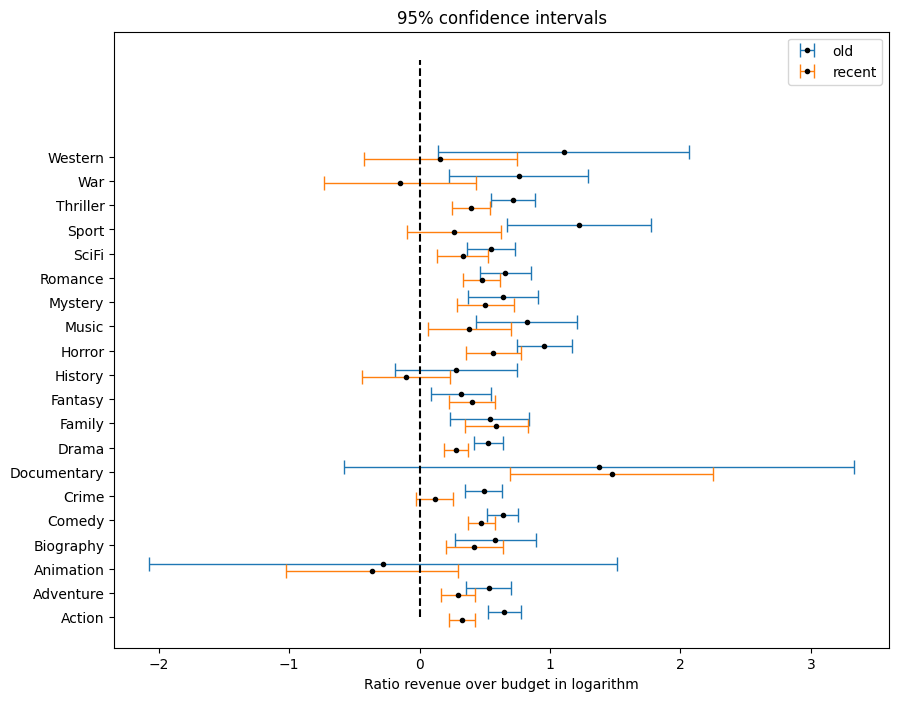

In [71]:
recent_CIs = []    
old_CIs = []    
    
for g in genre_names:
    difference_in_usage(old_movies, g=g, CI_list=old_CIs, measure='diff_log_rev_bud')
for g in genre_names:
    difference_in_usage(recent_movies, g=g, CI_list=recent_CIs, measure='diff_log_rev_bud')
    
plot_double_CIs(old_CIs, recent_CIs, genre_names, 'Ratio revenue over budget in logarithm')
plt.vlines(0, 0, 23, linestyle='--', color='black')
plt.show()

In general, the revenue is higher than the budget. No genre shows a significant higher budget (result below zero). Thriller, Sport, Drama, Crime, and Action had a significant higher difference between the budget and the revenue during the first period (before 2000). 
Western, War, Sport, Musical, Music, History, Documentary, Crime, and Animation movies, do not have significant higher revenue than budget in one of the two periods.  